In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
#load all the train data
import os
path = '/Users/rehanedin/Documents/neo_bank_churn/train'
files = os.listdir(path)
df = []

for f in files:
    filepath = os.path.join(path, f)
    data = pd.read_parquet(filepath)
    df.append(data)
    
final_df = pd.concat(df, ignore_index=True)

test_df = pd.read_parquet('test.parquet')
    
final_df.shape

(3926058, 26)

In [95]:
#ensure all train years are loaded
print(np.array(sorted(final_df['date'].dt.year.unique())))

#confirm against the filenames
print(np.array(sorted([int(f.split('_')[1].split('.')[0]) for f in files])))

#We have similar years!
np.array(sorted(final_df['date'].dt.year.unique())) == np.array(sorted([int(f.split('_')[1].split('.')[0]) for f in files]))

[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021
 2022 2023]
[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021
 2022 2023]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [96]:
final_df.info()
#test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3926058 entries, 0 to 3926057
Data columns (total 26 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   Id                        int64         
 1   customer_id               int64         
 2   interest_rate             float64       
 3   name                      object        
 4   country                   object        
 5   date_of_birth             object        
 6   address                   object        
 7   date                      datetime64[ns]
 8   atm_transfer_in           int64         
 9   atm_transfer_out          int64         
 10  bank_transfer_in          int64         
 11  bank_transfer_out         int64         
 12  crypto_in                 int64         
 13  crypto_out                int64         
 14  bank_transfer_in_volume   float64       
 15  bank_transfer_out_volume  float64       
 16  crypto_in_volume          float64       
 17  crypto_o

In [97]:
#update datatype of date_of_birth to datetime
final_df['date_of_birth'] = pd.to_datetime(final_df['date_of_birth'])
test_df['date_of_birth'] = pd.to_datetime(test_df['date_of_birth'])

In [98]:
#check for missing values
final_df.isna().sum()
#test_df.isna().sum()

Id                          0
customer_id                 0
interest_rate               0
name                        0
country                     0
date_of_birth               0
address                     0
date                        0
atm_transfer_in             0
atm_transfer_out            0
bank_transfer_in            0
bank_transfer_out           0
crypto_in                   0
crypto_out                  0
bank_transfer_in_volume     0
bank_transfer_out_volume    0
crypto_in_volume            0
crypto_out_volume           0
complaints                  0
touchpoints                 0
csat_scores                 0
tenure                      0
from_competitor             0
job                         0
churn_due_to_fraud          0
model_predicted_fraud       0
dtype: int64

In [99]:
final_df.head(3)

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,crypto_in_volume,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud
0,978127,1,0.0,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2014-07-25,0,0,...,93.277826,26.329383,0,[],"{'appointment': None, 'email': None, 'phone': ...",2381,False,Amenity horticulturist,False,False
1,978762,1,0.0,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2014-07-26,0,0,...,76.934630,24.028874,0,[],"{'appointment': None, 'email': None, 'phone': ...",2382,False,Amenity horticulturist,False,False
2,979413,1,0.0,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2014-07-27,0,0,...,80.553262,24.472070,0,[],"{'appointment': None, 'email': None, 'phone': ...",2383,False,Amenity horticulturist,False,False


In [100]:
# Expand csat scores into separate columns using one hot encoding
score_df = pd.json_normalize(final_df['csat_scores'])

# Convert to binary format
score_df = score_df.notnull().astype(int)

# Combine with original DataFrame
final_df = pd.concat([final_df, score_df], axis=1)

#add csat score counter and whether there was a score given
final_df['csat_score_count'] = final_df['appointment'] + final_df['email'] + final_df['whatsapp'] + final_df['phone']
final_df['gave_csat_score'] = final_df['csat_score_count'].apply(lambda x: 1 if x > 0 else 0)

In [101]:
# Repeat the step above for the test set
test_score_df = pd.json_normalize(test_df['csat_scores'])

# Convert to binary format
test_score_df = test_score_df.notnull().astype(int)

# Combine with original DataFrame
test_df = pd.concat([test_df, test_score_df], axis=1)

#add csat score counter and whether there was a score given
test_df['csat_score_count'] = test_df['appointment'] + test_df['email'] + test_df['whatsapp'] + test_df['phone']
test_df['gave_csat_score'] = test_df['csat_score_count'].apply(lambda x: 1 if x > 0 else 0)

In [102]:
# Expand touchpoints into separate columns
touchpoint_df = final_df['touchpoints'].apply(pd.Series)

# Convert to binary format
touchpoint_df = touchpoint_df.notnull().astype(int)

#rename cols
touchpoint_df= touchpoint_df.rename(columns = {0: 'touchpoint_0', 1:'touchpoint_1',2:'touchpoint_2'})

#create touchpoint counter and whether there was a touchpoint
touchpoint_df['touchpoint_count'] = touchpoint_df['touchpoint_0'] + touchpoint_df['touchpoint_1'] + touchpoint_df['touchpoint_2']
touchpoint_df['has_touchpoint'] = touchpoint_df['touchpoint_count'].apply(lambda x: 1 if x > 0 else 0)

# Combine touchpoints with original DataFrame
final_df = pd.concat([final_df, touchpoint_df], axis=1)

In [103]:
# Repeat the touchpoints step above into separate columns for test set
test_touchpoint_df = test_df['touchpoints'].apply(pd.Series)

# Convert to binary format
test_touchpoint_df = test_touchpoint_df.notnull().astype(int)

#rename cols
test_touchpoint_df = test_touchpoint_df.rename(columns = {0: 'touchpoint_0', 1:'touchpoint_1',2:'touchpoint_2'})

#create touchpoint counter and whether there was a touchpoint
test_touchpoint_df['touchpoint_count'] = test_touchpoint_df['touchpoint_0'] + test_touchpoint_df['touchpoint_1'] + test_touchpoint_df['touchpoint_2']
test_touchpoint_df['has_touchpoint'] = test_touchpoint_df['touchpoint_count'].apply(lambda x: 1 if x > 0 else 0)

# Combine touchpoints with original DataFrame
test_df = pd.concat([test_df, test_touchpoint_df], axis=1)

In [104]:
# Calculate customer age
from dateutil.relativedelta import relativedelta

final_df['customer_age'] = final_df.apply(
    lambda row: relativedelta(row['date'], row['date_of_birth']).years, axis=1
)

#test_df
test_df['customer_age'] = test_df.apply(
    lambda row: relativedelta(row['date'], row['date_of_birth']).years, axis=1
)


In [105]:
#find the event year
final_df['year'] = final_df['date'].dt.year
test_df['year'] = test_df['date'].dt.year

In [106]:
#let's see the customer account profile
final_df['atm_balance'] = final_df['atm_transfer_in']- final_df['atm_transfer_in']
test_df['atm_balance'] = test_df['atm_transfer_in']- test_df['atm_transfer_in']
final_df['bank_balance'] = final_df['bank_transfer_in']- final_df['bank_transfer_out']
test_df['bank_balance'] = test_df['bank_transfer_in']- test_df['bank_transfer_out']
final_df['crypto_balance'] = final_df['crypto_in']- final_df['crypto_out']
test_df['crypto_balance'] = test_df['crypto_in']- test_df['crypto_out']
final_df['bank_transfer_volume'] = final_df['bank_transfer_in_volume']- final_df['bank_transfer_out_volume']
test_df['bank_transfer_volume'] = test_df['bank_transfer_in_volume']- test_df['bank_transfer_out_volume']
final_df['crypto_volume'] = final_df['crypto_in_volume']- final_df['crypto_out_volume']
test_df['crypto_volume'] = test_df['crypto_in_volume']- test_df['crypto_out_volume']

final_df['account_balance'] = final_df['atm_balance'] + final_df['bank_balance'] + final_df['crypto_balance']+ final_df['bank_transfer_volume']+ final_df['crypto_volume']
test_df['account_balance'] = test_df['atm_balance'] + test_df['bank_balance'] + test_df['crypto_balance']+ test_df['bank_transfer_volume'] + test_df['crypto_volume']

In [107]:
#customer transaction frequency per year
final_df['customer_yrly_activity'] = final_df.groupby(['customer_id', 'year'])['date'].transform('count')
test_df['customer_yrly_activity'] = test_df.groupby(['customer_id', 'year'])['date'].transform('count')

In [108]:
#let's define churn using average number of yearly transaction with the bank
avg_customer_activity = final_df.groupby('year')['customer_yrly_activity'].mean()
avg_test_customer_activity = test_df.groupby('year')['customer_yrly_activity'].mean()

In [109]:
#let's create a threshold for churn (less than 50% of the yearly average frequency or if churn is due to fraud or account balance = 0)
#will not use touchpoint because customer may have a touchpoint but churned, and vice versa.
final_df['churn'] = final_df.apply(
    lambda row: 1 if row['customer_yrly_activity'] < (avg_customer_activity[row['year']] / 2) or row['churn_due_to_fraud'] or row['account_balance'] == 0 
    else 0,
    axis=1
)

test_df['churn'] = test_df.apply(
    lambda row: 1 if row['customer_yrly_activity'] < (avg_test_customer_activity[row['year']] / 2) or row['churn_due_to_fraud'] or row['account_balance'] == 0 
    else 0,
    axis=1
)

In [110]:
#let's see behavior by region to determine if we treat the different regions separately or not
final_df['country'].unique()
test_df['country'].unique()

array(['Belgium', 'Czech Republic', 'Lithuania', 'Austria', 'Ireland',
       'Slovakia', 'Denmark', 'Italy', 'Germany', 'Netherlands', 'Latvia',
       'Poland', 'Sweden', 'Portugal', 'Spain', 'Hungary', 'Norway',
       'Finland', 'USA', 'Bulgaria', 'Switzerland', 'Estonia', 'Greece',
       'France', 'Romania'], dtype=object)

In [111]:
region_mapping = {
    'Lithuania': 'Eastern Europe',
    'Netherlands': 'Western Europe',
    'Hungary': 'Eastern Europe',
    'Denmark': 'Northern Europe',
    'Norway': 'Northern Europe',
    'Bulgaria': 'Eastern Europe',
    'Italy': 'Southern Europe',
    'Switzerland': 'Western Europe',
    'Ireland': 'Western Europe',
    'Sweden': 'Northern Europe',
    'Czech Republic': 'Eastern Europe',
    'Greece': 'Southern Europe',
    'Germany': 'Western Europe',
    'Romania': 'Eastern Europe',
    'Latvia': 'Eastern Europe',
    'Belgium': 'Western Europe',
    'Portugal': 'Southern Europe',
    'Finland': 'Northern Europe',
    'Spain': 'Southern Europe',
    'Estonia': 'Eastern Europe',
    'Austria': 'Western Europe',
    'Slovakia': 'Eastern Europe',
    'France': 'Western Europe',
    'Poland': 'Eastern Europe',
    'USA': 'USA'
}
final_df['region'] = final_df['country'].map(region_mapping)
test_df['region'] = test_df['country'].map(region_mapping)

In [112]:
#Count occurrences by region
region_counts = final_df.groupby('region').size()
print(region_counts)
#we see that eastern europe has a larger number of rows than the rest- we may have to deal with the region imbalance
#can use oversampling minority class, undersampling or SMOTE so let's use SMOTE(synthetic minority oversampling technique) 

region
Eastern Europe     1405318
Northern Europe     635143
Southern Europe     620370
USA                 160034
Western Europe     1105193
dtype: int64


In [113]:
numeric_cols = ['interest_rate','bank_transfer_in_volume','bank_transfer_out_volume','atm_transfer_in','atm_transfer_out', 'crypto_in',
                'crypto_out', 'bank_transfer_in','bank_transfer_out','crypto_in_volume','crypto_out_volume','customer_age',
                'complaints','tenure','customer_yrly_activity', 'atm_balance', 'bank_balance','crypto_balance','bank_transfer_volume',
                'crypto_volume','account_balance']

In [114]:
means_by_region = final_df.groupby('region')[numeric_cols].mean()
print(means_by_region)
#the mean values across regions seem to be similar- let's see if there's a significant variance within the regions

                 interest_rate  bank_transfer_in_volume  \
region                                                    
Eastern Europe        0.527588              1791.254346   
Northern Europe       0.509800              1793.767090   
Southern Europe       0.511836              1803.132106   
USA                   0.515886              1822.496287   
Western Europe        0.526736              1786.236632   

                 bank_transfer_out_volume  atm_transfer_in  atm_transfer_out  \
region                                                                         
Eastern Europe                1113.193894         0.317730          0.620709   
Northern Europe               1112.666098         0.239028          0.267406   
Southern Europe               1124.622422         0.475112          0.266185   
USA                           1141.384786         0.475243          0.144301   
Western Europe                1109.064527         0.232421          0.370467   

                 crypto_i

In [115]:
# Check standard deviation for each numeric column grouped by region
std_dev_by_region = final_df.groupby('region')[numeric_cols].std()
print(std_dev_by_region)
#The regions don't seem to differ significantly so we will treat them as similar- dont need to look into the region imbalance concern

                 interest_rate  bank_transfer_in_volume  \
region                                                    
Eastern Europe        1.047803              3117.855729   
Northern Europe       1.033565              3101.912063   
Southern Europe       1.035072              3153.430796   
USA                   1.033935              3151.381583   
Western Europe        1.047441              3123.114390   

                 bank_transfer_out_volume  atm_transfer_in  atm_transfer_out  \
region                                                                         
Eastern Europe                2740.214146        19.235937         29.295504   
Northern Europe               2727.035603        16.083889         18.332261   
Southern Europe               2773.540722        24.520224         18.744756   
USA                           2775.876320        25.526086          8.845464   
Western Europe                2744.603372        17.104621         21.802745   

                 crypto_i

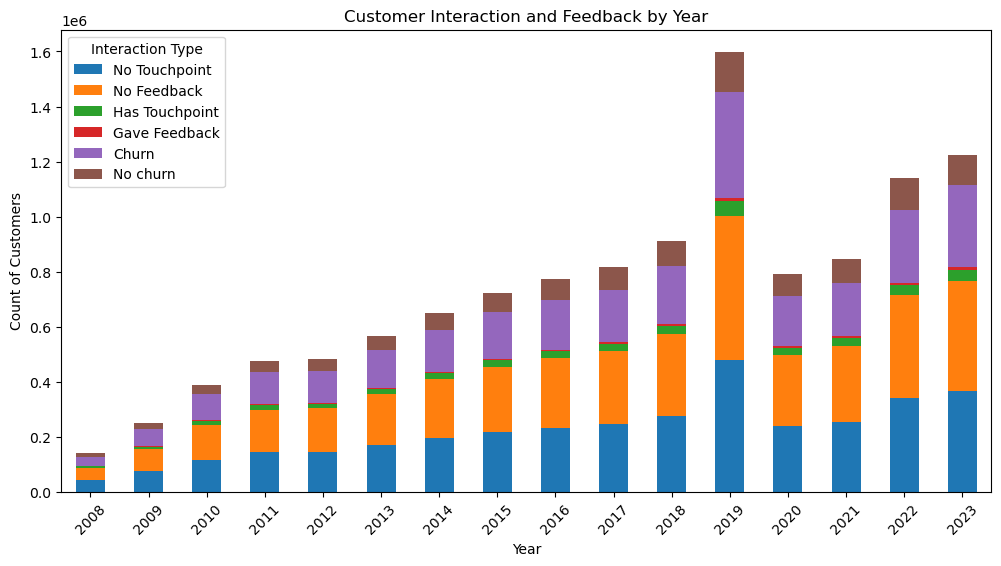

In [123]:
#how many customers are contacting us; how many are providing feedback

touchpoint_counts = final_df.groupby(['year', 'has_touchpoint']).size().unstack(fill_value=0)
feedback_counts = final_df.groupby(['year', 'gave_csat_score']).size().unstack(fill_value=0)
churn_counts = final_df.groupby(['year', 'churn']).size().unstack(fill_value=0)

# Rename the columns to distinguish them
touchpoint_counts.columns = ['No Touchpoint', 'Has Touchpoint']
feedback_counts.columns = ['No Feedback', 'Gave Feedback']
churn_counts.columns = ['Churn', 'No churn']

# Concatenate the two DataFrames
combined_counts = pd.concat([touchpoint_counts, feedback_counts,churn_counts], axis=1)

# Plot the combined results
combined_counts = combined_counts[['No Touchpoint', 'No Feedback','Has Touchpoint','Gave Feedback','Churn', 'No churn']]
combined_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Customer Interaction and Feedback by Year')
plt.xlabel('Year')
plt.ylabel('Count of Customers')
plt.xticks(rotation=45)
plt.legend(title='Interaction Type')
plt.show()

#our customers aren't talking to us and if they do, they dont provide feedback- should investigate our marketing tactics

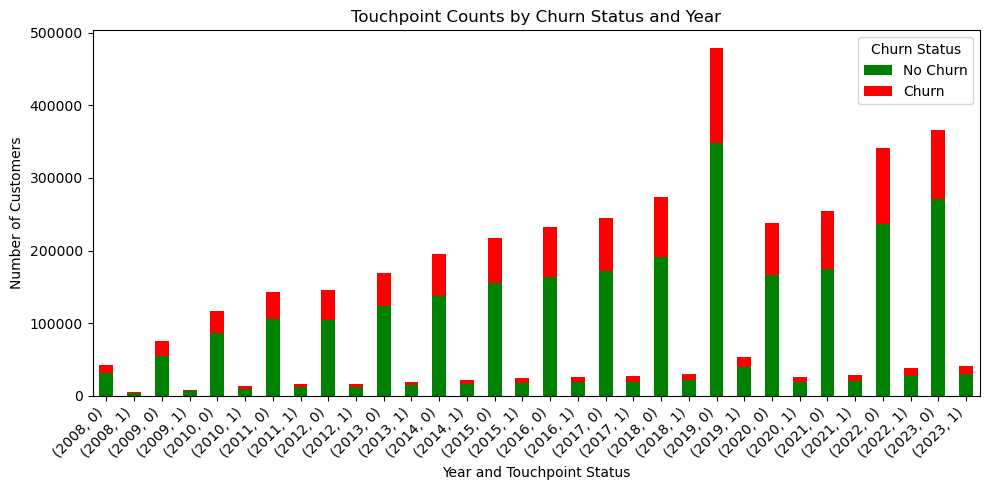

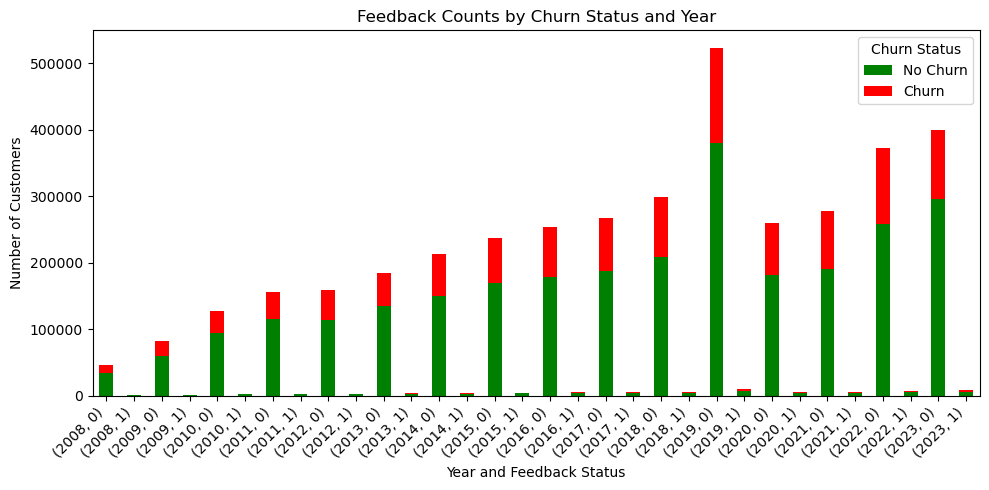

In [125]:
# Group by year and churn status for touchpoints and feedback 
touchpoint_churn_counts = final_df.groupby(['year', 'has_touchpoint', 'churn']).size().unstack(fill_value=0)
feedback_churn_counts = final_df.groupby(['year', 'gave_csat_score', 'churn']).size().unstack(fill_value=0)

# Prepare for plotting: Separate Touchpoints and Feedback into individual DataFrames
touchpoint_churn_counts.columns = ['No Churn', 'Churn']
feedback_churn_counts.columns = ['No Churn', 'Churn']

# Plot touchpoint counts
touchpoint_churn_counts.plot(kind='bar', stacked=True, figsize=(10, 5), color=['green', 'red'])
plt.title('Touchpoint Counts by Churn Status and Year')
plt.xlabel('Year and Touchpoint Status')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Churn Status')
plt.tight_layout()
plt.show()

# Plot feedback counts
feedback_churn_counts.plot(kind='bar', stacked=True, figsize=(10, 5), color=['green', 'red'])
plt.title('Feedback Counts by Churn Status and Year')
plt.xlabel('Year and Feedback Status')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Churn Status')
plt.tight_layout()
plt.show()

#very few clients provide feedback after contacting us. we need a strategy for that. Cant tell 
#from the charts if having a touchpoint or csat score affects churning. We can confirm statistically.

In [127]:
#let's check if there's any relationship btn having touchpoint and churn; giving feedback and churn; complaining and churn; tenure and churn

from scipy.stats import chi2_contingency

# Create a crosstab of touchpoint vs churn
tp_crosstab = pd.crosstab(final_df['has_touchpoint'], final_df['churn'])
csat_crosstab = pd.crosstab(final_df['gave_csat_score'], final_df['churn'])
complaints_crosstab = pd.crosstab(final_df['complaints'], final_df['churn'])
tenure_crosstab = pd.crosstab(final_df['tenure'], final_df['churn'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(tp_crosstab)
csat_chi2, csat_p, csat_dof, csat_expected = chi2_contingency(csat_crosstab)
complaints_chi2, complaints_p, complaints_dof, complaints_expected = chi2_contingency(complaints_crosstab)
tenure_chi2, tenure_p, tenure_dof, tenure_expected = chi2_contingency(tenure_crosstab)

# Print the result
print(f"Chi2 Stat for has touchpoint: {chi2}, P-value: {p}")
print(f"Chi2 Stat for gave csat score: {csat_chi2}, P-value: {csat_p}")
print(f"Chi2 Stat for complaints: {complaints_chi2}, P-value: {complaints_p}")
print(f"Chi2 Stat for tenure: {tenure_chi2}, P-value: {tenure_p}")

#There's a statistically significant relationship btn tenure and churn

Chi2 Stat for has touchpoint: 0.523450026056563, P-value: 0.4693736980035501
Chi2 Stat for gave csat score: 0.5568630422303907, P-value: 0.45552693898919283
Chi2 Stat for complaints: 7.291786687060624, P-value: 0.06315674381038025
Chi2 Stat for tenure: 505786.91966610047, P-value: 0.0


In [129]:
#let's convert from_competitor, churn_due_to_fraud, model_predicted_fraud into integers
final_df['churn_due_to_fraud'].astype(int)
final_df['from_competitor'].astype(int)
final_df['model_predicted_fraud'].astype(int)

#do the same for the test data
test_df['churn_due_to_fraud'].astype(int)
test_df['from_competitor'].astype(int)
test_df['model_predicted_fraud'].astype(int)

0          0
1          0
2          0
3          0
4          0
          ..
1360467    0
1360468    0
1360469    0
1360470    0
1360471    0
Name: model_predicted_fraud, Length: 1360472, dtype: int64

In [131]:
#so now we can redefine our numerical columns
new_numeric_cols = ['customer_yrly_activity','from_competitor','churn_due_to_fraud','model_predicted_fraud']
numeric_cols.extend(new_numeric_cols)

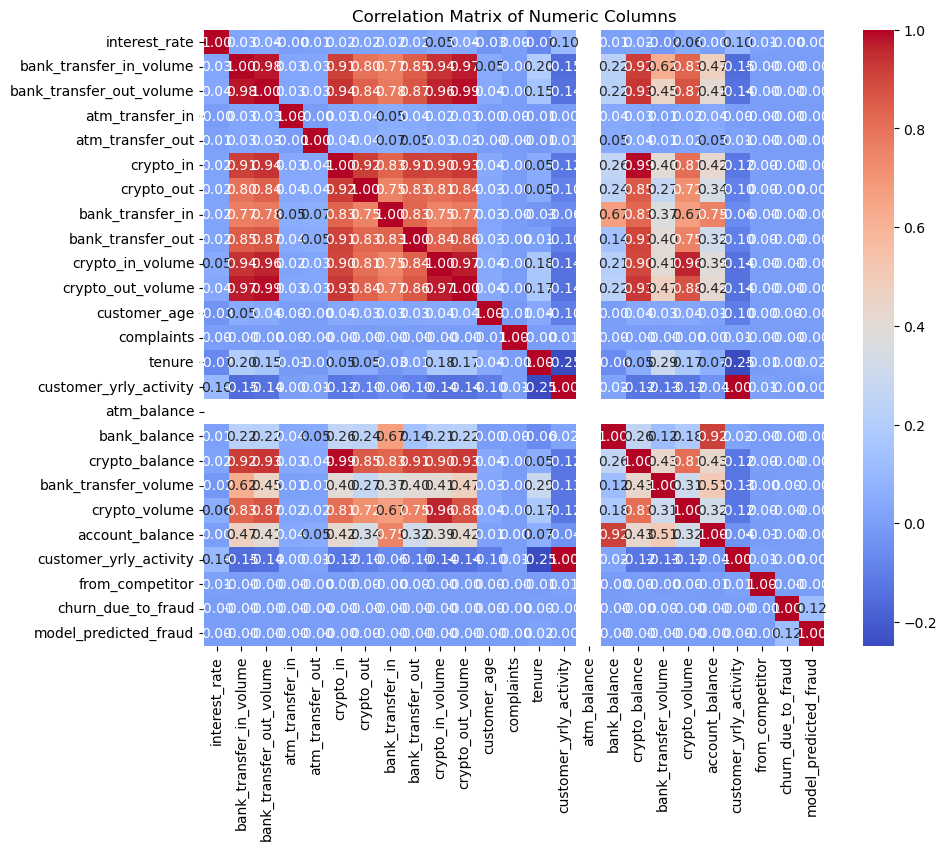

In [133]:
#let's see if any of them is correlated
# visualize
correlation = final_df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Columns")
plt.show()


In [135]:
# let's have a correlation threshold of .8
threshold = 0.8

abs_correlation = correlation.abs()

# Select the upper triangle of the correlation matrix
upper_triangle = abs_correlation.where(np.triu(np.ones(abs_correlation.shape), k=1).astype(bool))

# Find and drop cols with correlation greater than the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]


#let's confirm customerids in test and train are not similar to avoid leakage
train_custids = final_df['customer_id'].unique()
test_custids= test_df['customer_id'].unique()

test_customers = [customer for customer in test_custids if customer not in train_custids]

# Filter out customers that are in the test set from the train set
train_filtered_df = final_df[~final_df['customer_id'].isin(test_customers)]


model_df = train_filtered_df[numeric_cols]
model_df = model_df.drop(columns=to_drop)

test_model = test_df[numeric_cols]
test_model = test_model.drop(columns=to_drop)

#confirm we can merge the model and churn col- ie have same number of rows
print(model_df.shape)
print(len(final_df['churn']))

print(test_model.shape)
print(len(test_df['churn']))

(3926058, 13)
3926058
(1360472, 13)
1360472


In [137]:
# Count the values for each class in the target variable to determine if there's a target variable imbalance
target_counts = train_filtered_df['churn'].value_counts()
imbalance_ratio = target_counts / target_counts.sum()

print(imbalance_ratio)
#doesn't seem significantly imbalanced

churn
0    0.713208
1    0.286792
Name: count, dtype: float64


In [139]:
#Now we can move on to modeling. Predicting churn is a classification question

from sklearn.model_selection import train_test_split

X = model_df
y = train_filtered_df['churn']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shapes of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3140846, 13)
X_test shape: (785212, 13)
y_train shape: (3140846,)
y_test shape: (785212,)


In [141]:
#let's start with logistic regression. we'll standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #fit and transform on train data
X_test_scaled = scaler.transform(X_test) #only transform on test data

In [143]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg.fit(X_train_scaled, y_train)

#Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix, log_loss

# Predictions
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nLog Loss:")
log_loss_value = log_loss(y_test, y_prob)
print(log_loss_value)

#The model doesn't do a good job- the model identifies only 9% of actual churn cases and when it predicts churn, only 53% of predictions are correct.

Confusion Matrix:
[[542055  17964]
 [205236  19957]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.97      0.83    560019
           1       0.53      0.09      0.15    225193

    accuracy                           0.72    785212
   macro avg       0.63      0.53      0.49    785212
weighted avg       0.67      0.72      0.63    785212


Log Loss:
0.5769212989379447


In [145]:
#let's see catboost
from catboost import CatBoostClassifier

# Initialize the model
cat_model = CatBoostClassifier(
    iterations=100,  # Number of trees
    depth=6,         # Tree depth
    learning_rate=0.1,
    random_seed=42,
    verbose=False,   # Suppresses training output
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])
)

# Train the model
cat_model.fit(X_train, y_train)

# Predict probabilities
y_pred_cat = cat_model.predict(X_test)
y_prob_cat = cat_model.predict_proba(X_test)[:, 1]


# Evaluation
print("\nCatBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_cat))

print("\nCatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))

print("\nCatBoost Log Loss:")
cat_log_loss = log_loss(y_test, y_prob_cat)
print(cat_log_loss)

#better than logistic regression but with a higher log loss. 


CatBoost Confusion Matrix:
[[366450 193569]
 [ 67031 158162]]

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.65      0.74    560019
           1       0.45      0.70      0.55    225193

    accuracy                           0.67    785212
   macro avg       0.65      0.68      0.64    785212
weighted avg       0.73      0.67      0.68    785212


CatBoost Log Loss:
0.5951818673625121


In [147]:
#finally, let's see how xgboost performs
from xgboost import XGBClassifier

# Initialize the model
xgb_model = XGBClassifier(n_estimators=900, max_depth=9, learning_rate=0.1, random_state=42, scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

# Train the model
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=900, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [149]:
# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Gradient Boosting (XGBoost) Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nGradient Boosting (XGBoost) Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("\nGradient Boosting (XGBoost) Log Loss:")
log_loss_value = log_loss(y_test, y_prob_xgb)
print("Log Loss:", log_loss_value)

#high recall for churners which is good
#looks like the dataset is imbalanced as there's a large difference btn TP and TN- let's correct that using SMOTE

Gradient Boosting (XGBoost) Confusion Matrix:
[[372116 187903]
 [ 59985 165208]]

Gradient Boosting (XGBoost) Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.66      0.75    560019
           1       0.47      0.73      0.57    225193

    accuracy                           0.68    785212
   macro avg       0.66      0.70      0.66    785212
weighted avg       0.75      0.68      0.70    785212


Gradient Boosting (XGBoost) Log Loss:
Log Loss: 0.5581442229296976


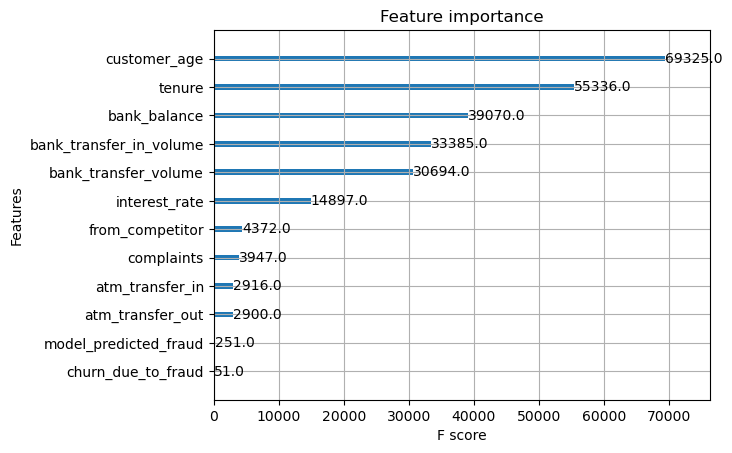

In [159]:
# First, let's plot feature importance
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model, max_num_features=13)
plt.show()
#we can remove model_predicted_fraud and churn_due_to_fraud

In [163]:
new_train_cols = ['interest_rate', 'bank_transfer_in_volume', 'atm_transfer_in',
       'atm_transfer_out', 'customer_age', 'complaints', 'tenure',
       'atm_balance', 'bank_balance', 'bank_transfer_volume',
       'from_competitor']
X_train_new = X_train[new_train_cols]
X_test_new = X_test[new_train_cols]

In [177]:
#we'll use smote 
from imblearn.over_sampling import SMOTE
from collections import Counter

#let's check the class distribution before SMOTE
print(f"Class distribution before SMOTE: {Counter(y_train)}")

#Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_new, y_train)

#Check the class distribution after SMOTE
print(f"Class distribution after SMOTE: {Counter(y_train_resampled)}")

Class distribution before SMOTE: Counter({0: 2240076, 1: 900770})
Class distribution after SMOTE: Counter({1: 2240076, 0: 2240076})


In [179]:
# let's check against the cat boost model as well
cat_model_resampled = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=False,
    scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])
)

# Train the model
cat_model_resampled.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
y_pred_cat_resampled = cat_model_resampled.predict(X_test_new)
y_prob_cat_resampled = cat_model_resampled.predict_proba(X_test_new)[:, 1]


# Evaluation
print("\nCatBoost Confusion Matrix (Resampled Data):")
print(confusion_matrix(y_test, y_pred_cat_resampled))

print("\nCatBoost Classification Report (Resampled Data):")
print(classification_report(y_test, y_pred_cat_resampled))

print("\nCatBoost Log Loss (Resampled Data):")
print(log_loss(y_test, y_prob_cat_resampled))

#let's see how it compares against xgboost on resampled data.


CatBoost Confusion Matrix (Resampled Data):
[[404345 155674]
 [ 87283 137910]]

CatBoost Classification Report (Resampled Data):
              precision    recall  f1-score   support

           0       0.82      0.72      0.77    560019
           1       0.47      0.61      0.53    225193

    accuracy                           0.69    785212
   macro avg       0.65      0.67      0.65    785212
weighted avg       0.72      0.69      0.70    785212


CatBoost Log Loss (Resampled Data):
0.573561189330682


In [181]:
#fit the xgb model on the resampled data
xgb_model_resampled = XGBClassifier(n_estimators=900, max_depth= 9, learning_rate=0.1, random_state=42, 
                                    scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1]))
xgb_model_resampled.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate the model
y_pred_resampled = xgb_model_resampled.predict(X_test_new)
y_prob_resampled = xgb_model_resampled.predict_proba(X_test_new)[:, 1]

# Evaluate performance
print("\nXGB Confusion Matrix (Resampled Data):")
print(confusion_matrix(y_test, y_pred_resampled))

print("\n XGB Classification Report (Resampled Data):")
print(classification_report(y_test, y_pred_resampled))

print("\n XGB Log loss (Resampled Data):")
print(log_loss(y_test, y_prob_resampled))

#recall: The model is able to identify 65% of the actual churn cases.
#precision: when the model predicts churn, it is correct only 48% of the time.
#f1-score: This is a balance between precision and recall, showing moderate performance.
#log-loss improved a little after resampling


XGB Confusion Matrix (Resampled Data):
[[401434 158585]
 [ 78053 147140]]

 XGB Classification Report (Resampled Data):
              precision    recall  f1-score   support

           0       0.84      0.72      0.77    560019
           1       0.48      0.65      0.55    225193

    accuracy                           0.70    785212
   macro avg       0.66      0.69      0.66    785212
weighted avg       0.74      0.70      0.71    785212


 XGB Log loss (Resampled Data):
0.541455146978536


In [189]:
#ensure the two columns are dropped for the test data as well
print(test_model.shape)
test_x=test_model[new_train_cols]

In [191]:
# Predictions and probabilities using the resampled model

y_prob_resampled = xgb_model_resampled.predict_proba(test_x)[:, 1]  # Probabilities for the positive class
y_pred_resampled = xgb_model_resampled.predict(test_x)  # Class predictions

# Evaluate performance
print("\nXGB Confusion Matrix on Test Data:")
print(confusion_matrix(test_df['churn'], y_pred_resampled))

print("\nPerformance of xgb_model_resampled on Test Data:")
print(classification_report(test_df['churn'], y_pred_resampled))
print("Log Loss:", log_loss(test_df['churn'], y_prob_resampled))


XGB Confusion Matrix on Test Data:
[[422262 563993]
 [158185 216032]]

Performance of xgb_model_resampled on Test Data:
              precision    recall  f1-score   support

           0       0.73      0.43      0.54    986255
           1       0.28      0.58      0.37    374217

    accuracy                           0.47   1360472
   macro avg       0.50      0.50      0.46   1360472
weighted avg       0.60      0.47      0.49   1360472

Log Loss: 2.6091641246771076


In [193]:
len(list(y_prob_resampled))

1360472

In [195]:
submission = pd.read_csv('sample_submission.csv')
submission.head(3)

,Id,churn
0,6187320,0.5
1,6187321,0.5
2,6187322,0.5


In [197]:
sub = pd.DataFrame({'Id': test_df['Id'],'churn': y_prob_resampled})
sub.to_csv('neo_bank_churn_submission.csv', index=False)